Generating predictions...


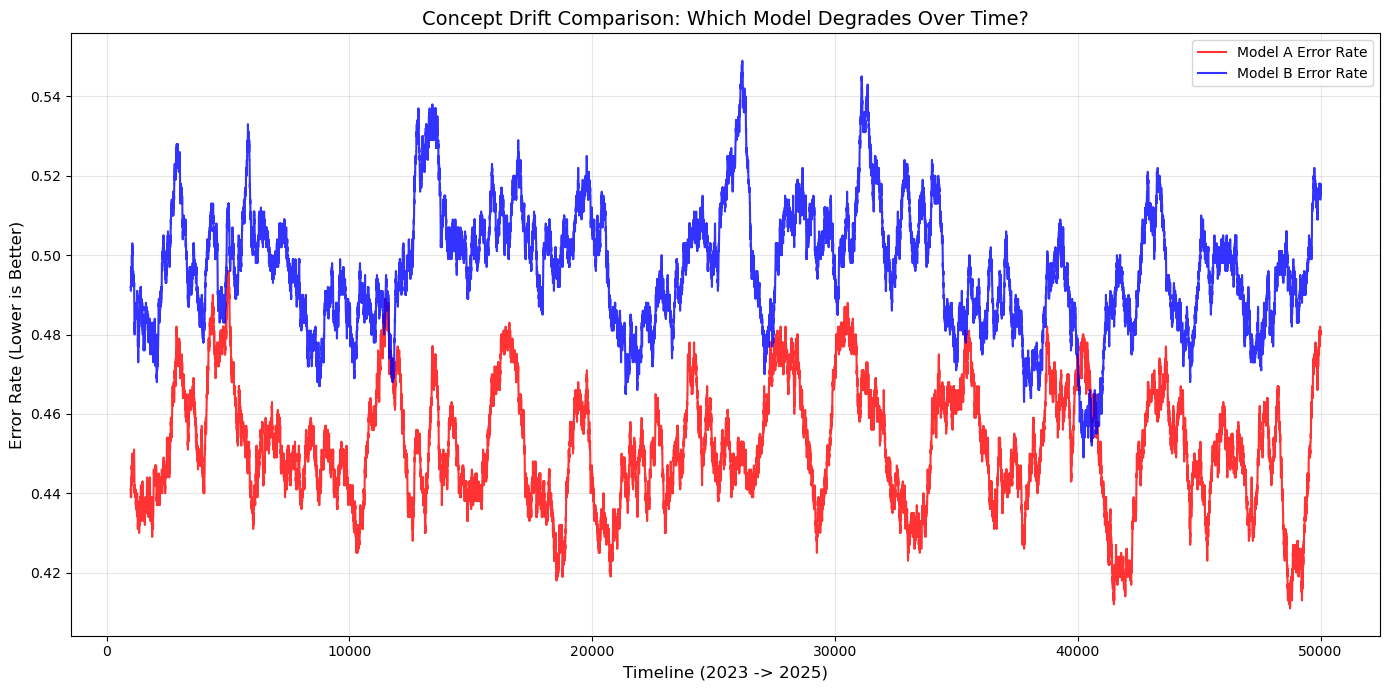

Overall Accuracy Model A: 54.80%
Overall Accuracy Model B: 50.30%
CONCLUSION: Model A is more robust overall.


In [2]:
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt

# 1. Load and Sort Data (Chronological Order)
df = pd.read_csv('click_prediction.csv')
df = df.sort_values(by=['year', 'day_of_year']).reset_index(drop=True)

# Define features (Same mapping as before)
feature_cols = [
    'year', 'day_of_year', 'time_of_day', 'device_type', 'location', 
    'age', 'browser', 'OS', 'ad_style_category', 
    'part_of_add_evaluation_focus_group', 'provided_feedback_about_add'
] + [f'visited_good_{i}' for i in range(10)] + [f'purchased_good_{i}' for i in range(10)]

X = df[feature_cols]
y_true = df['clicked_on_add'].values
dtest = xgb.DMatrix(X)

# 2. Load BOTH Models in the same script
model_a = xgb.Booster()
model_a.load_model('add_model_A.json')

model_b = xgb.Booster()
model_b.load_model('add_model_B.json')

# 3. Generate Predictions for both
print("Generating predictions...")
y_prob_a = model_a.predict(dtest)
y_pred_a = (y_prob_a > 0.5).astype(int)

y_prob_b = model_b.predict(dtest)
y_pred_b = (y_prob_b > 0.5).astype(int)

# 4. Create Error Streams (1 = Wrong Prediction, 0 = Correct)
error_a = (y_pred_a != y_true).astype(int)
error_b = (y_pred_b != y_true).astype(int)

# 5. Comparative Visualization
plt.figure(figsize=(14, 7), dpi=100)

# Calculate Rolling Error Rate (Window = 1000 samples)
# This smooths the line so you can see the "trend" of accuracy
roll_err_a = pd.Series(error_a).rolling(window=1000).mean()
roll_err_b = pd.Series(error_b).rolling(window=1000).mean()

plt.plot(roll_err_a, label='Model A Error Rate', color='red', linewidth=1.5, alpha=0.8)
plt.plot(roll_err_b, label='Model B Error Rate', color='blue', linewidth=1.5, alpha=0.8)

plt.title('Concept Drift Comparison: Which Model Degrades Over Time?', fontsize=14)
plt.xlabel('Timeline (2023 -> 2025)', fontsize=12)
plt.ylabel('Error Rate (Lower is Better)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 6. Statistical Summary for Presentation
avg_err_a = error_a.mean()
avg_err_b = error_b.mean()

print(f"Overall Accuracy Model A: {(1-avg_err_a)*100:.2f}%")
print(f"Overall Accuracy Model B: {(1-avg_err_b)*100:.2f}%")

if avg_err_a < avg_err_b:
    print("CONCLUSION: Model A is more robust overall.")
else:
    print("CONCLUSION: Model B is more robust overall.")